In [30]:
site_names = {'AD': 'Asylum Down',
             'ASH' : 'Ashaiman',
             'EL': 'East Legon',
             'JT' : 'James Town',
             'LA': 'Labadi',
             'N1W': 'N1 West Motorway',
             'NM': 'Nima',
             'TF': 'Taifa',
             'TMW': 'Tema Motorway',
             'UGH': 'University of Ghana'}

  0%|                                                                                                                                                                                 | 0/7 [00:08<?, ?it/s]

KeyboardInterrupt



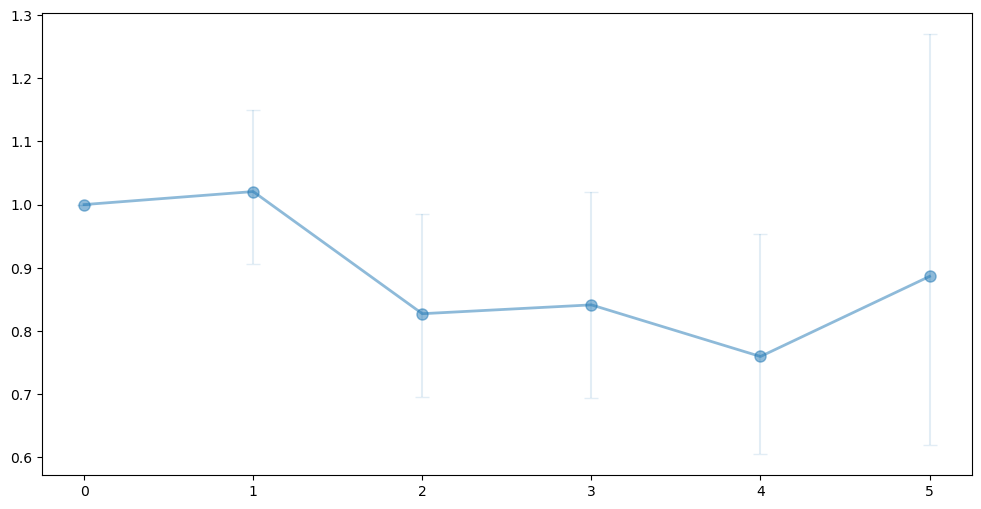

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import spearmanr
from tqdm import tqdm

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Modified check_trend function to return detailed information
def check_trend(estimates, lower_bounds, upper_bounds, num_bootstrap=10000):
    # Remove NaNs from estimates
    valid_indices = ~np.isnan(estimates)
    estimates = estimates[valid_indices]
    lower_bounds = lower_bounds[valid_indices]
    upper_bounds = upper_bounds[valid_indices]
    if len(estimates) < 2:
        return {
            'spearman_corr': None,
            'spearman_ci': (None, None),
            'is_significant': False
        }

    year_values = np.arange(len(estimates))

    # Compute Spearman correlation on the central estimates
    # corr, _ = spearmanr(year_values, estimates)

    # Bootstrapping to estimate 95% CI of Spearman correlation
    # Sampling from within the 95% confidence intervals of the estimates
    bootstrap_corrs = []
    for _ in range(num_bootstrap):
        # For each estimate, sample a value from a uniform distribution between lower and upper bounds
        sampled_estimates = np.random.uniform(lower_bounds, upper_bounds)
        # Compute Spearman correlation
        sample_corr, _ = spearmanr(year_values, sampled_estimates)
        bootstrap_corrs.append(sample_corr)

    # Compute 95% confidence interval
    lower_ci = np.percentile(bootstrap_corrs, 2.5)
    upper_ci = np.percentile(bootstrap_corrs, 97.5)
    corr = np.percentile(bootstrap_corrs, 50) # USE FOR MEDIAN TREND

    # Determine significance
    is_significant = (lower_ci > 0) or (upper_ci < 0)

    return {
        'spearman_corr': corr,
        'spearman_ci': (lower_ci, upper_ci),
        'is_significant': is_significant
    }

# Modified plotting function
def plot_total_year_effects_all_sites_with_trends(sites, super_category, year_labels, title):
    plt.figure(figsize=(12, 6))

    # Modified colormap section
    colormap = plt.get_cmap('tab10')  # Use 'get_cmap' to access the colormap
    colors = [colormap(i % 10) for i in range(len(sites))]  # Correct way to get colors


    all_estimates = []  # To track all central estimates for y-axis scaling
    label_info_list = []  # To store label information for each site

    for idx, site in enumerate(sites):
        # Load the model data for the current site and category
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue

        model_df = pd.read_csv(filepath)

        estimates = [1]  # Adding the reference category (2019) with an effect of 1
        lower_bounds = [1]  # The lower bound for the reference category
        upper_bounds = [1]  # The upper bound for the reference category

        # Iterate over the year labels to extract coefficients
        for year in year_labels:
            main_term = f'year{year}'
            row = model_df[model_df['term'] == main_term]

            if not row.empty:
                coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
                estimates.append(coef)
                lower_bounds.append(lower)
                upper_bounds.append(upper)
            else:
                estimates.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)

        # Include '2019' in the labels for the reference category
        full_year_labels = ['2019'] + year_labels

        # Convert lists to numpy arrays
        estimates = np.array(estimates)
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)

        # Keep track of all central estimates for setting y-axis limits later
        all_estimates.extend(estimates[~np.isnan(estimates)])

        # Compute trend_info
        trend_info = check_trend(estimates, lower_bounds, upper_bounds)

        # Identify valid data points
        valid_indices = ~np.isnan(estimates)
        x_values = np.arange(len(full_year_labels))[valid_indices]
        estimates = estimates[valid_indices]
        lower_bounds = lower_bounds[valid_indices]
        upper_bounds = upper_bounds[valid_indices]
        year_labels_valid = np.array(full_year_labels)[valid_indices]

        # For significant trends, adjust plotting parameters
        if trend_info['is_significant']:
            zorder_line = 4
            zorder_marker = 4
            linewidth = 6
            markersize = 12
            alpha_line = 1
            alpha_marker = 1

            # Plot the white shadow effect behind the main lines and markers
            plt.plot(
                x_values,
                estimates,
                color='white',
                linestyle='-',
                linewidth=linewidth + 4,
                alpha=1,
                zorder=zorder_line - 1
            )
            plt.errorbar(
                x_values,
                estimates,
                yerr=None,
                fmt='o',
                color='white',
                markersize=markersize + 4,
                alpha=1,
                zorder=zorder_marker - 1
            )
        else:
            # Default plotting parameters
            zorder_line = 2
            zorder_marker = 2
            linewidth = 2
            markersize = 8
            alpha_line = 0.5
            alpha_marker = 0.5

        # Plot the whiskers (error bars)
        plt.errorbar(
            x_values,
            estimates,
            yerr=[estimates - lower_bounds, upper_bounds - estimates],
            fmt='none',
            ecolor=colors[idx],
            alpha=0.125,
            capsize=5,
            elinewidth=1.5,
            zorder=zorder_line - 1
        )

        # Plot lines connecting the points
        plt.plot(
            x_values,
            estimates,
            color=colors[idx],
            linestyle='-',
            linewidth=linewidth,
            alpha=alpha_line,
            zorder=zorder_line
        )

        # Plot the central points
        plt.errorbar(
            x_values,
            estimates,
            yerr=None,
            fmt='o',
            color=colors[idx],
            capsize=5,
            markersize=markersize,
            alpha=alpha_marker,
            elinewidth=1.5,
            label=f'{site_names[site]}',
            zorder=zorder_marker
        )

        # Collect label info
        if len(estimates) > 0:
            # Get the position of the last valid data point
            last_x = x_values[-1]
            label_x = len(full_year_labels) - 0.8  # Align labels at the same x-position
            data_y = estimates[-1]

            # Prepare label text
            spearman_corr = trend_info['spearman_corr']
            arrow = '▲' if (spearman_corr  > 0 and trend_info['is_significant']) else '▼' if (spearman_corr < 0 and trend_info['is_significant']) else ''
            spearman_ci = trend_info['spearman_ci']
            if spearman_corr is not None and spearman_ci[0] is not None and spearman_ci[1] is not None:
                label_text = f"{arrow} {spearman_corr:.2f} ({spearman_ci[0]:.2f}, {spearman_ci[1]:.2f})"
            else:
                label_text = "N/A"

            # Store label info
            label_info_list.append({
                'label_x': label_x,
                'data_y': data_y,
                'label_text': label_text,
                'is_significant': trend_info['is_significant'],
                'color': colors[idx],
                'zorder': zorder_marker + 1,
                'site': site,
                'data_x': last_x
            })

    # Remove gridlines and adjust plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(False)

    # Add a thicker black line at y=1 to represent the reference level
    plt.axhline(y=1, color='black', linewidth=2, linestyle='--')
    plt.axhline(y=0, color='grey', linewidth=1, alpha=0.75)

    # Set the y-axis limits
    if all_estimates:
        max_estimate = max(all_estimates)
        min_estimate = min(all_estimates)
        y_range = max_estimate - min_estimate
        y_axis_min = min_estimate - y_range * 0.1
        y_axis_max = max_estimate + y_range * 0.1
        plt.ylim(y_axis_min, y_axis_max)
    else:
        y_axis_min, y_axis_max = plt.gca().get_ylim()
        y_range = y_axis_max - y_axis_min

    # Now adjust label positions to be evenly spaced from just above x-axis to just below top of y-axis
    n_labels = len(label_info_list)
    if n_labels > 1:
        label_positions = np.linspace(y_axis_min + y_range * 0.05, y_axis_max - y_range * 0.05, n_labels)
    else:
        label_positions = [(y_axis_min + y_axis_max) / 2]

    # Sort label_info_list by data_y (final y-values) ascending to maintain order from bottom to top
    label_info_list.sort(key=lambda x: x['data_y'])

    # Assign label y-positions according to the sorted order
    for i, label_info in enumerate(label_info_list):
        label_y = label_positions[i]
        label_info['label_y'] = label_y

    # Now plot labels and connectors
    for label_info in label_info_list:
        # Plot connector line from data point to label
        plt.plot(
            [label_info['data_x'], label_info['label_x']],
            [label_info['data_y'], label_info['label_y']],
            color='black',
            linestyle='-',
            linewidth=1,
            zorder=label_info['zorder']
        )

        # Plot the label
        bbox_props = dict(facecolor='white', alpha=1)
        if label_info['is_significant']:
            bbox_props['linewidth'] = 2  # Twice the line width for significant trends
            fontsize = 14
        else:
            bbox_props['linewidth'] = 1
            fontsize = 10

        plt.text(
            label_info['label_x'],
            label_info['label_y'],
            label_info['label_text'],
            color=label_info['color'],
            fontsize=fontsize,
            va='center',
            ha='left',
            zorder=label_info['zorder'],
            bbox=bbox_props
        )

    # Set x-ticks with labels
    plt.xticks(ticks=range(len(full_year_labels)), labels=full_year_labels, rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Multiplicative Effect on Counts')
    plt.title(title)
    plt.legend(loc='upper left')

    # Create directory if it doesn't exist
    output_dir = './results/time_series_by_category/year/'
    os.makedirs(output_dir, exist_ok=True)

    # Save the figure
    plt.savefig(f'{output_dir}/{title.replace(" ", "_")}_total_year_effects_{super_category}_median_trend.png', bbox_inches='tight')
    plt.close()

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']

for super_category in tqdm(super_categories):
    # Plot total year effects for all sites, including trend annotations
    year_labels = ['2020', '2021', '2022', '2023', '2024']  # Assuming '2019' as the reference
    plot_total_year_effects_all_sites_with_trends(
        sites,
        super_category,
        year_labels,
        f'Total Effect of Year on {super_category.replace("_"," ").capitalize()} Counts'
    )


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import spearmanr
from tqdm import tqdm
from matplotlib.lines import Line2D  # Import Line2D for custom legend handles

# Function to calculate the confidence intervals and coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Modified check_trend function to return detailed information
def check_trend(estimates, lower_bounds, upper_bounds, num_bootstrap=10000):
    # Remove NaNs from estimates
    valid_indices = ~np.isnan(estimates)
    estimates = estimates[valid_indices]
    lower_bounds = lower_bounds[valid_indices]
    upper_bounds = upper_bounds[valid_indices]
    if len(estimates) < 2:
        return {
            'spearman_corr': None,
            'spearman_ci': (None, None),
            'is_significant': False
        }

    year_values = np.arange(len(estimates))

    # Compute Spearman correlation using bootstrapping
    bootstrap_corrs = []
    for _ in range(num_bootstrap):
        # Sample within the confidence intervals
        sampled_estimates = np.random.uniform(lower_bounds, upper_bounds)
        # Compute Spearman correlation
        sample_corr, _ = spearmanr(year_values, sampled_estimates)
        bootstrap_corrs.append(sample_corr)

    # Compute confidence intervals
    lower_ci = np.percentile(bootstrap_corrs, 2.5)
    upper_ci = np.percentile(bootstrap_corrs, 97.5)
    corr = np.percentile(bootstrap_corrs, 50)  # Median trend

    # Determine significance
    is_significant = (lower_ci > 0) or (upper_ci < 0)

    return {
        'spearman_corr': corr,
        'spearman_ci': (lower_ci, upper_ci),
        'is_significant': is_significant
    }

# Modified plotting function
def plot_total_year_effects_all_sites_with_trends(sites, super_category, year_labels, title, ax=None, site_color_map=None):
    # If ax is None, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    all_estimates = []  # To track all central estimates for y-axis scaling
    label_info_list = []  # To store label information for each site

    for idx, site in enumerate(sites):
        # Load the model data for the current site and category
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue

        model_df = pd.read_csv(filepath)

        estimates = [1]  # Reference category (2019)
        lower_bounds = [1]
        upper_bounds = [1]

        # Iterate over the year labels to extract coefficients
        for year in year_labels:
            main_term = f'year{year}'
            row = model_df[model_df['term'] == main_term]

            if not row.empty:
                coef, lower, upper = calculate_effects_and_ci(row.iloc[0])
                estimates.append(coef)
                lower_bounds.append(lower)
                upper_bounds.append(upper)
            else:
                estimates.append(np.nan)
                lower_bounds.append(np.nan)
                upper_bounds.append(np.nan)

        # Include '2019' in the labels
        full_year_labels = ['2019'] + year_labels

        # Convert lists to numpy arrays
        estimates = np.array(estimates)
        lower_bounds = np.array(lower_bounds)
        upper_bounds = np.array(upper_bounds)

        # Keep track of all central estimates for y-axis limits
        all_estimates.extend(estimates[~np.isnan(estimates)])

        # Compute trend_info
        trend_info = check_trend(estimates, lower_bounds, upper_bounds)

        # Identify valid data points
        valid_indices = ~np.isnan(estimates)
        x_values = np.arange(len(full_year_labels))[valid_indices]
        estimates = estimates[valid_indices]
        lower_bounds = lower_bounds[valid_indices]
        upper_bounds = upper_bounds[valid_indices]
        year_labels_valid = np.array(full_year_labels)[valid_indices]

        # Get the color for this site
        color = site_color_map[site]

        # For significant trends, adjust plotting parameters
        if trend_info['is_significant']:
            zorder_line = 4
            zorder_marker = 4
            linewidth = 6
            markersize = 12
            alpha_line = 1
            alpha_marker = 1

            # Plot the white shadow effect
            ax.plot(
                x_values,
                estimates,
                color='white',
                linestyle='-',
                linewidth=linewidth + 4,
                alpha=1,
                zorder=zorder_line - 1
            )
            ax.errorbar(
                x_values,
                estimates,
                yerr=None,
                fmt='o',
                color='white',
                markersize=markersize + 4,
                alpha=1,
                zorder=zorder_marker - 1
            )
        else:
            # Default plotting parameters
            zorder_line = 2
            zorder_marker = 2
            linewidth = 2
            markersize = 8
            alpha_line = 0.5
            alpha_marker = 0.5

        # Plot the error bars
        ax.errorbar(
            x_values,
            estimates,
            yerr=[estimates - lower_bounds, upper_bounds - estimates],
            fmt='none',
            ecolor=color,
            alpha=0.125,
            capsize=5,
            elinewidth=1.5,
            zorder=zorder_line - 1
        )

        # Plot lines connecting the points
        ax.plot(
            x_values,
            estimates,
            color=color,
            linestyle='-',
            linewidth=linewidth,
            alpha=alpha_line,
            zorder=zorder_line
        )

        # Plot the central points
        ax.errorbar(
            x_values,
            estimates,
            yerr=None,
            fmt='o',
            color=color,
            capsize=5,
            markersize=markersize,
            alpha=alpha_marker,
            elinewidth=1.5,
            label=f'{site_names[site]}',
            zorder=zorder_marker
        )

        # Collect label info
        if len(estimates) > 0:
            # Position of the last valid data point
            last_x = x_values[-1]
            label_x = len(full_year_labels) - 0.8  # Align labels
            data_y = estimates[-1]

            # Prepare label text
            spearman_corr = trend_info['spearman_corr']
            arrow = '▲' if (spearman_corr  > 0 and trend_info['is_significant']) else '▼' if (spearman_corr < 0 and trend_info['is_significant']) else ''
            spearman_ci = trend_info['spearman_ci']
            if spearman_corr is not None and spearman_ci[0] is not None and spearman_ci[1] is not None:
                label_text = f"{arrow} {spearman_corr:.2f} ({spearman_ci[0]:.2f}, {spearman_ci[1]:.2f})"
            else:
                label_text = "N/A"

            # Store label info
            label_info_list.append({
                'label_x': label_x,
                'data_y': data_y,
                'label_text': label_text,
                'is_significant': trend_info['is_significant'],
                'color': color,
                'zorder': zorder_marker + 1,
                'site': site,
                'data_x': last_x
            })

    # Adjust plot aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Add reference lines
    ax.axhline(y=1, color='black', linewidth=2, linestyle='--')
    ax.axhline(y=0, color='grey', linewidth=1, alpha=0.75)

    # Set the y-axis limits
    if all_estimates:
        max_estimate = max(all_estimates)
        min_estimate = min(all_estimates)
        y_axis_min = 0  # Start y-axis from 0
        y_range = max_estimate - y_axis_min
        y_axis_max = max_estimate + y_range * 0.1
        ax.set_ylim(y_axis_min, y_axis_max)
    else:
        y_axis_min, y_axis_max = ax.get_ylim()
        y_range = y_axis_max - y_axis_min

    # Adjust label positions
    n_labels = len(label_info_list)
    if n_labels > 1:
        label_positions = np.linspace(y_axis_min + y_range * 0.05, y_axis_max - y_range * 0.05, n_labels)
    else:
        label_positions = [(y_axis_min + y_axis_max) / 2]

    # Sort labels
    label_info_list.sort(key=lambda x: x['data_y'])

    # Assign label y-positions
    for i, label_info in enumerate(label_info_list):
        label_y = label_positions[i]
        label_info['label_y'] = label_y

    # Plot labels and connectors
    for label_info in label_info_list:
        # Connector line
        ax.plot(
            [label_info['data_x'], label_info['label_x']],
            [label_info['data_y'], label_info['label_y']],
            color='black',
            linestyle='-',
            linewidth=1,
            zorder=label_info['zorder']
        )

        # Label
        bbox_props = dict(facecolor='white', alpha=1)
        if label_info['is_significant']:
            bbox_props['linewidth'] = 2  # Thicker for significant trends
            fontsize = 22
        else:
            bbox_props['linewidth'] = 1
            fontsize = 10

        ax.text(
            label_info['label_x'],
            label_info['label_y'],
            label_info['label_text'],
            color=label_info['color'],
            fontsize=fontsize,
            va='center',
            ha='left',
            zorder=label_info['zorder'],
            bbox=bbox_props
        )

    # Set x-ticks with labels
    ax.set_xticks(range(len(full_year_labels)))
    ax.set_xticklabels(full_year_labels, rotation=45)
    if(title=='Market'):
        ax.set_ylabel('Multiplicative Effect on Counts', fontsize=30)
    ax.set_title(title, fontsize=28)

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH']
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal']
year_labels = ['2020', '2021', '2022', '2023', '2024']  # Assuming '2019' as the reference

# Define colormap and colors
colormap = plt.get_cmap('tab10')
colors = [colormap(i % 10) for i in range(len(sites))]
site_color_map = dict(zip(sites, colors))

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(30, 20))

# Define positions for the seven plots
axes_positions = [ (0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,1) ]

for idx, (super_category, pos) in tqdm(enumerate(zip(super_categories, axes_positions))):
    ax = axs[pos[0]][pos[1]]
    title = f'{super_category.replace("_"," ").capitalize()}'
    plot_total_year_effects_all_sites_with_trends(
        sites,
        super_category,
        year_labels,
        title,
        ax=ax,
        site_color_map=site_color_map
    )
    ax.spines['bottom'].set_visible(False)

# Turn off the axes for empty subplots
axs[2][0].axis('off')
axs[2][2].axis('off')

# Create custom legend handles
handles = []
labels = []
for site in sites:
    color = site_color_map[site]
    line = Line2D([0], [0], color=color, marker='o', linestyle='None', markersize=20)
    handles.append(line)
    labels.append(site_names[site])

# Create a legend outside the subplots
leg = fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.825, 0.25), ncols=2, fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend

# Save the figure
output_dir = './results/time_series_by_category/year/'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(f'{output_dir}/Total_Effect_of_Year_on_Counts_combined_plots.png', bbox_inches='tight')
plt.close()


7it [05:12, 44.60s/it]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to combine main and interaction effects
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef, _, _ = calculate_effects_and_ci(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef, _, _ = calculate_effects_and_ci(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
    else:
        combined_estimate = main_coef
    
    return combined_estimate

# Function to get total day effects for a given model dataframe
def get_total_day_effects(model_df, day_labels):
    estimates = []
    for day_idx, day in enumerate(day_labels, start=1):
        if day == 'Monday':
            # Monday is the reference category with an effect of 1
            estimates.append(1)
        else:
            main_term = f'day{day_idx}'
            main_row = model_df[model_df['term'] == main_term]
            
            interaction_estimates = []
            # Combine main and interaction effects across all hours
            for hour in range(1, 24):
                interaction_term = f'hour{hour}:day{day_idx}'
                interaction_row = model_df[model_df['term'] == interaction_term]
                
                if not main_row.empty and not interaction_row.empty:
                    combined_estimate = combine_main_and_interaction_effects(
                        main_row.iloc[0], interaction_row
                    )
                    interaction_estimates.append(combined_estimate)
            if interaction_estimates:
                # Average over all hours to get the day's effect
                avg_estimate = np.mean(interaction_estimates)
                estimates.append(avg_estimate)
            else:
                estimates.append(np.nan)
    return estimates

# Function to plot radar chart of day effects for all sites with scaling option
def plot_radar_day_effects_all_sites(sites, super_category, day_labels, title, scale_by_median=False, ax=None):
    site_day_effects = {}
    site_day_effects_original = {}
    for site in sites:
        # Load model coefficients
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue
        model_df = pd.read_csv(filepath)
        estimates = get_total_day_effects(model_df, day_labels)
        site_day_effects[site] = estimates

    # Apply scaling if requested
    if scale_by_median:
        site_day_effects_original = {}
        for site in site_day_effects:
            values = np.array(site_day_effects[site])
            # Compute median excluding NaNs
            median_value = np.nanmedian(values)
            if median_value != 0:
                # Scale values so that median becomes 1
                values_scaled = values / median_value
                # Divide by 2 so that median is at 0.5 on the plot
                scaled_values = values_scaled / 2
                site_day_effects[site] = scaled_values.tolist()
                # Store values_scaled for labeling
                site_day_effects_original[site] = values_scaled.tolist()
            else:
                # Avoid division by zero
                site_day_effects[site] = values.tolist()
                site_day_effects_original[site] = values.tolist()
    else:
        for site in site_day_effects:
            site_day_effects_original[site] = site_day_effects[site]

    # Number of variables we're plotting (7 days)
    num_vars = len(day_labels)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the loop
    angles += angles[:1]

    # If ax is None, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

    # Get the colormap
    colormap = plt.get_cmap('tab10')
    colors = [colormap(i % 10) for i in range(len(sites))]

    # Dictionary to hold the labels for data points beyond the plot
    labels_outside = {}

    for idx_site, site in enumerate(site_day_effects.keys()):
        values = np.array(site_day_effects[site])  # Values after scaling by median and dividing by 2
        values_original = np.array(site_day_effects_original[site])  # Values after scaling by median
        # Handle missing values (NaNs)
        values = np.nan_to_num(values, nan=np.nan)
        values_original = np.nan_to_num(values_original, nan=np.nan)
        # Prepare lists for plotting
        values_plot = values.tolist()
        values_plot += values_plot[:1]
        # Similarly for original values
        values_original_plot = values_original.tolist()
        values_original_plot += values_original_plot[:1]
        # Plot the line for the site
        ax.plot(angles, values_plot, label=site_names[site], color=colors[idx_site], linewidth=3)
        # For values within the plot radius, plot the markers
        for i, (angle, val_plot, val_original_plot) in enumerate(zip(angles, values_plot, values_original_plot)):
            if not np.isnan(val_plot) and val_plot <= 1:
                # Plot the marker
                ax.scatter(angle, val_plot, color=colors[idx_site], s=75)
            elif not np.isnan(val_plot) and val_plot > 1:
                # Data point exceeds plot radius, collect for labeling
                day = i % num_vars  # day index
                if day not in labels_outside:
                    labels_outside[day] = []
                labels_outside[day].append({
                    'site': site,
                    'value': val_original_plot,  # value after scaling by median
                    'color': colors[idx_site],
                    'order': idx_site  # Keep track of site index for consistent ordering
                })
        # For the line, we need to handle data that goes beyond the plot
        # Matplotlib will clip the line automatically

    # Set the labels for each axis (day labels)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(day_labels)

    # Adjust the radial limits
    ax.set_ylim(0, 1)

    # Set radial ticks and labels
    r_ticks = np.linspace(0, 1, 5)  # [0., 0.25, 0.5, 0.75, 1.]
    r_tick_labels = [f"{rtick*2:.1f}" for rtick in r_ticks]  # Multiply by 2 to get back to values before dividing by 2
    ax.set_yticks(r_ticks)
    ax.set_yticklabels(r_tick_labels)

    # Add a thicker black circular line at r=0.5 (which now represents the median)
    theta_line = np.linspace(0, 2 * np.pi, 100)
    r_line = np.ones_like(theta_line) * 0.5
    ax.plot(theta_line, r_line, color='black', linewidth=3, linestyle='--')

    # Now, handle the labels for data points beyond the plot
    for day_idx in labels_outside:
        day_angle = angles[day_idx]
        entries = labels_outside[day_idx]
        # Sort entries by value to determine placement (smaller values closer to plot)
        entries_sorted = sorted(entries, key=lambda x: x['value'])
        for idx_label, entry in enumerate(entries_sorted):
            # Determine radial position for label
            r_label = 1.3 + 0.2 * idx_label  # Adjust to prevent overlap
            # Adjust angle slightly to prevent overlap with day labels
            angle_offset = 0.0
            if abs(day_angle - np.pi/2) < 0.1 or abs(day_angle - 3*np.pi/2) < 0.1:
                angle_offset = 0.1 * (-1)**idx_label  # Adjust angle slightly
            angle_label = day_angle + angle_offset
            # Add label below the dot
            ax.text(angle_label, r_label - 0.02, f"●\n{entry['value']:.2f}", color=entry['color'],
                    fontsize=14, ha='center', va='top')
    # Adjust the plot to prevent labels from overlapping with day labels
    ax.set_rlabel_position(0)  # Move radial labels away from day labels

    # Add title to the subplot
    ax.set_title(title, size=30, y=1.08)

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20), subplot_kw=dict(polar=True))

# Define positions for the seven plots
axes_positions = [ (0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,1) ]

for idx, (super_category, pos) in enumerate(zip(super_categories, axes_positions)):
    ax = axs[pos[0]][pos[1]]
    title = f'{super_category.replace("_"," ").capitalize()}'
    plot_radar_day_effects_all_sites(
        sites,
        super_category,
        day_labels,
        title,
        scale_by_median=True,
        ax=ax
    )

# Turn off the axes for empty subplots
axs[2][0].axis('off')
axs[2][2].axis('off')

# Get handles and labels from one of the axes (e.g., the first one)
handles, labels = axs[0][0].get_legend_handles_labels()

# Create a legend outside the subplots
leg = fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.825, 0.25), ncols=2, fontsize=18)
# set the linewidth of each legend object
for legobj in leg.legend_handles:
    legobj.set_linewidth(10)
    
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space at the bottom for the legend

# Save the figure
output_dir = f'./results/time_series_by_category/day/'
os.makedirs(output_dir, exist_ok=True)

scaling_suffix = '_scaled_by_median'  # Since scale_by_median=True

plt.savefig(f'{output_dir}/Total_Effect_of_Day_on_Counts_radar_plot{scaling_suffix}.png', bbox_inches='tight')
plt.close()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to calculate the coefficients
def calculate_effects_and_ci(row):
    coef = row['estimate']
    lower = row['conf.low']
    upper = row['conf.high']
    return coef, lower, upper

# Function to combine main and interaction effects
def combine_main_and_interaction_effects(main_row, interaction_row=None):
    main_coef, _, _ = calculate_effects_and_ci(main_row)
    
    if interaction_row is not None and not interaction_row.empty:
        inter_coef, _, _ = calculate_effects_and_ci(interaction_row.iloc[0])
        combined_estimate = np.exp(np.log(main_coef) + np.log(inter_coef))
    else:
        combined_estimate = main_coef
    
    return combined_estimate

# Function to get total day effects for a given model dataframe
def get_total_day_effects(model_df, day_labels):
    estimates = []
    for day_idx, day in enumerate(day_labels, start=1):
        if day == 'Monday':
            # Monday is the reference category with an effect of 1
            estimates.append(1)
        else:
            main_term = f'day{day_idx}'
            main_row = model_df[model_df['term'] == main_term]
            
            interaction_estimates = []
            # Combine main and interaction effects across all hours
            for hour in range(1, 24):
                interaction_term = f'hour{hour}:day{day_idx}'
                interaction_row = model_df[model_df['term'] == interaction_term]
                
                if not main_row.empty and not interaction_row.empty:
                    combined_estimate = combine_main_and_interaction_effects(
                        main_row.iloc[0], interaction_row
                    )
                    interaction_estimates.append(combined_estimate)
            if interaction_estimates:
                # Average over all hours to get the day's effect
                avg_estimate = np.mean(interaction_estimates)
                estimates.append(avg_estimate)
            else:
                estimates.append(np.nan)
    return estimates

# Function to plot radar chart of day effects for all sites with scaling option
def plot_radar_day_effects_all_sites(sites, super_category, day_labels, title, scaling_method=None, ax=None):
    site_day_effects = {}
    site_day_effects_original = {}
    for site in sites:
        # Load model coefficients
        filepath = f'./FULL_MODEL_RESULTS/{site}_{super_category}_conditional_model_coefficients.csv'
        if not os.path.exists(filepath):
            print(f"File not found for {site} - {super_category}")
            continue
        model_df = pd.read_csv(filepath)
        estimates = get_total_day_effects(model_df, day_labels)
        site_day_effects[site] = estimates

    # Apply scaling if requested
    if scaling_method == 'median':
        # Scaling by median
        site_day_effects_original = {}
        for site in site_day_effects:
            values = np.array(site_day_effects[site])
            # Compute median excluding NaNs
            median_value = np.nanmedian(values)
            if median_value != 0:
                # Scale values so that median becomes 1
                values_scaled = values / median_value
                site_day_effects[site] = values_scaled.tolist()
                # Store values_scaled for labeling
                site_day_effects_original[site] = values_scaled.tolist()
            else:
                # Avoid division by zero
                site_day_effects[site] = values.tolist()
                site_day_effects_original[site] = values.tolist()
    elif scaling_method == 'maximum':
        # Scaling by maximum
        site_day_effects_original = {}
        for site in site_day_effects:
            values = np.array(site_day_effects[site])
            # Compute maximum excluding NaNs
            max_value = np.nanmax(values)
            if max_value != 0:
                # Scale values so that maximum becomes 1
                values_scaled = values / max_value
                site_day_effects[site] = values_scaled.tolist()
                # Store values_scaled for labeling
                site_day_effects_original[site] = values_scaled.tolist()
            else:
                # Avoid division by zero
                site_day_effects[site] = values.tolist()
                site_day_effects_original[site] = values.tolist()
    else:
        # No scaling
        for site in site_day_effects:
            site_day_effects_original[site] = site_day_effects[site]

    # Number of variables we're plotting (7 days)
    num_vars = len(day_labels)

    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the loop
    angles += angles[:1]

    # If ax is None, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

    # Get the colormap
    colormap = plt.get_cmap('tab10')
    colors = [colormap(i % 10) for i in range(len(sites))]

    # Dictionary to hold the labels for data points beyond the plot
    labels_outside = {}

    for idx_site, site in enumerate(site_day_effects.keys()):
        values = np.array(site_day_effects[site])  # Values after scaling
        values_original = np.array(site_day_effects_original[site])  # Values after scaling
        # Handle missing values (NaNs)
        values = np.nan_to_num(values, nan=np.nan)
        values_original = np.nan_to_num(values_original, nan=np.nan)
        # Prepare lists for plotting
        values_plot = values.tolist()
        values_plot += values_plot[:1]
        # Similarly for original values
        values_original_plot = values_original.tolist()
        values_original_plot += values_original_plot[:1]
        # Plot the line for the site
        ax.plot(angles, values_plot, label=site_names[site], color=colors[idx_site], linewidth=3)
        # For values within the plot radius, plot the markers
        for i, (angle, val_plot, val_original_plot) in enumerate(zip(angles, values_plot, values_original_plot)):
            if not np.isnan(val_plot) and val_plot <= 1:
                # Plot the marker
                ax.scatter(angle, val_plot, color=colors[idx_site], s=75)
            elif not np.isnan(val_plot) and val_plot > 1:
                # Data point exceeds plot radius, collect for labeling
                day = i % num_vars  # day index
                if day not in labels_outside:
                    labels_outside[day] = []
                labels_outside[day].append({
                    'site': site,
                    'value': val_original_plot,  # value after scaling
                    'color': colors[idx_site],
                    'order': idx_site  # Keep track of site index for consistent ordering
                })
        # For the line, we need to handle data that goes beyond the plot
        # Matplotlib will clip the line automatically

    # Set the labels for each axis (day labels)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(day_labels)

    # Adjust the radial limits
    ax.set_ylim(0, 1.2)  # Slightly beyond 1 to provide space for labels

    # Set radial ticks and labels
    r_ticks = np.linspace(0, 1, 5)  # [0., 0.25, 0.5, 0.75, 1.]
    r_tick_labels = [f"{rtick:.1f}" for rtick in r_ticks]
    ax.set_yticks(r_ticks)
    ax.set_yticklabels(r_tick_labels)

    # Remove the dotted reference line (since we're not scaling by median)
    # (Commented out the code that adds the reference line)

    # Now, handle the labels for data points beyond the plot
    for day_idx in labels_outside:
        day_angle = angles[day_idx]
        entries = labels_outside[day_idx]
        # Sort entries by value to determine placement (smaller values closer to plot)
        entries_sorted = sorted(entries, key=lambda x: x['value'])
        for idx_label, entry in enumerate(entries_sorted):
            # Determine radial position for label
            r_label = 1.05 + 0.1 * idx_label  # Adjust to prevent overlap
            # Adjust angle slightly to prevent overlap with day labels
            angle_offset = 0.0
            if abs(day_angle - np.pi/2) < 0.1 or abs(day_angle - 3*np.pi/2) < 0.1:
                angle_offset = 0.1 * (-1)**idx_label  # Adjust angle slightly
            angle_label = day_angle + angle_offset
            # Add label below the dot
            ax.text(angle_label, r_label - 0.02, f"●\n{entry['value']:.2f}", color=entry['color'],
                    fontsize=10, ha='center', va='top')
    # Adjust the plot to prevent labels from overlapping with day labels
    ax.set_rlabel_position(0)  # Move radial labels away from day labels

    # Add title to the subplot
    ax.set_title(title, size=12, y=1.08)

# Main execution
sites = ['AD', 'ASH', 'EL', 'JT', 'LA', 'N1W', 'NM', 'TF', 'TMW', 'UGH'] 
super_categories = ['people', 'small_vehicles', 'large_vehicles', 'market', 'two_wheelers', 'refuse', 'animal'] 
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 20), subplot_kw=dict(polar=True))

# Define positions for the seven plots
axes_positions = [ (0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,1) ]

for idx, (super_category, pos) in enumerate(zip(super_categories, axes_positions)):
    ax = axs[pos[0]][pos[1]]
    title = f'{super_category.replace("_"," ").capitalize()}'
    plot_radar_day_effects_all_sites(
        sites,
        super_category,
        day_labels,
        title,
        scaling_method='maximum',  # Set scaling method to 'maximum'
        ax=ax
    )

# Turn off the axes for empty subplots
axs[2][0].axis('off')
axs[2][2].axis('off')

# Get handles and labels from one of the axes (e.g., the first one)
handles, labels = axs[0][0].get_legend_handles_labels()

# Create a legend outside the subplots
leg = fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.825, 0.25), ncols=2, fontsize=18)
# set the linewidth of each legend object
for legobj in leg.legend_handles:
    legobj.set_linewidth(10)
    
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space at the bottom for the legend

# Save the figure
output_dir = f'./results/time_series_by_category/day/'
os.makedirs(output_dir, exist_ok=True)

scaling_suffix = '_scaled_by_maximum'  # Since scaling_method='maximum'

plt.savefig(f'{output_dir}/Total_Effect_of_Day_on_Counts_radar_plot{scaling_suffix}.png', bbox_inches='tight')
plt.close()
